# Time series forecasting project

In [2]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima

## 1. Data loading

### 1.1. Load

In [3]:
raw_data_df=sns.load_dataset('flights')

### 1.2. Inspect 

In [4]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


### 1.3. Encode date feature

Pandas has many great tools to work with timeseries data - see the user guide article: '*[Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)*'. First thing to do is convert our string date feature(s) to a Datetime object.

In [5]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2. EDA

### 2.1. Baseline model performance

Let's set a quick performance baseline using a quick/easy linear regression model and a 'carry forward' model.

#### 2.1.1. Linear model baseline

Linear Regression RMSE: 45.74


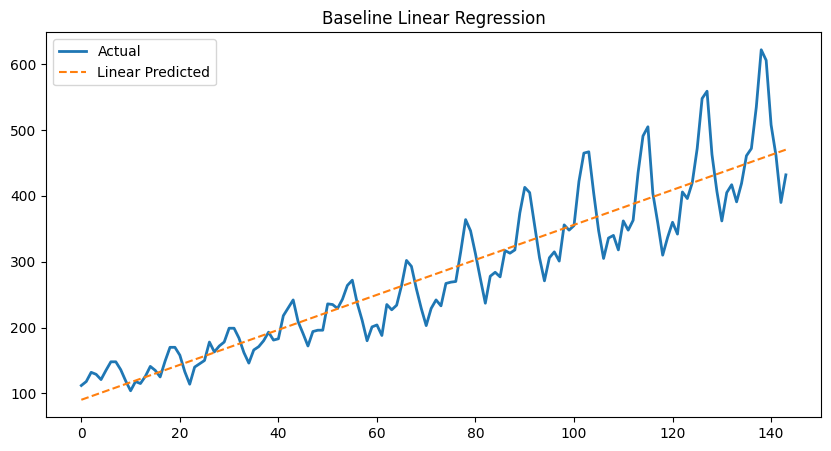

In [6]:
# Your code here! Hint use a numeric range equal to the length of the dataset for x.
# Create a simple numeric x range 
X = np.arange(len(timeseries_df)).reshape(-1, 1)
y = timeseries_df['dependent_var'].values

# Fit a linear regression model
lr = LinearRegression()
lr.fit(X, y)

# Make predictions
y_pred = lr.predict(X)

# Evaluate model performance
rmse = sqrt(mean_squared_error(y, y_pred))
print(f"Linear Regression RMSE: {rmse:.2f}")

# Optional: Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y, label='Actual', linewidth=2)
plt.plot(y_pred, label='Linear Predicted', linestyle='--')
plt.title("Baseline Linear Regression")
plt.legend()
plt.show()


#### 2.1.2. 'Carry forward' baseline

The 'carry forward' baseline uses the precding value as the prediction for the next. How does it do?

Carry Forward RMSE: 33.71


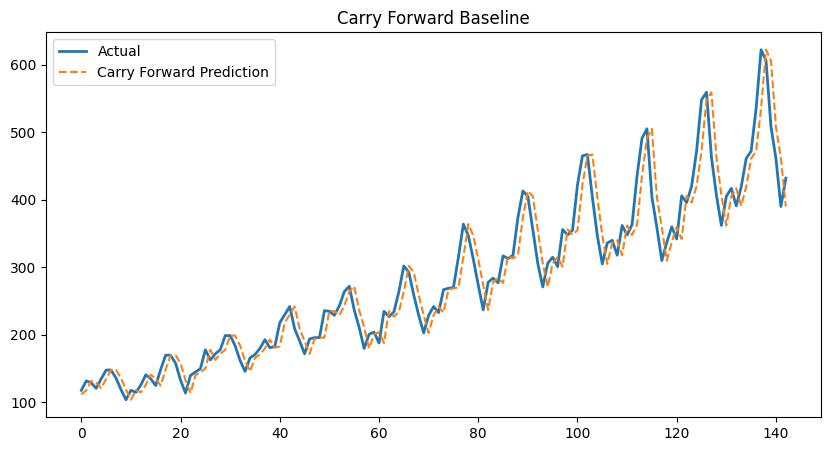

In [ ]:
# Your code here - hint try making a copy of the data and shifting it by one point.
# Make a copy of the data
data_copy = timeseries_df.copy()

# Create a new column where each value is the previous value of 'dependent_var'
data_copy['prediction'] = data_copy['dependent_var'].shift(1)

# Drop the first row (it will have NaN in prediction)
data_copy.dropna(inplace=True)

# Evaluate the carry forward model using RMSE
rmse_cf = sqrt(mean_squared_error(data_copy['dependent_var'], data_copy['prediction']))
print(f"Carry Forward RMSE: {rmse_cf:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(data_copy['dependent_var'].values, label='Actual', linewidth=2)
plt.plot(data_copy['prediction'].values, label='Carry Forward Prediction', linestyle='--')
plt.title("Carry Forward Baseline")
plt.legend()
plt.show()


### 2.2. Missing, and/or extreme values

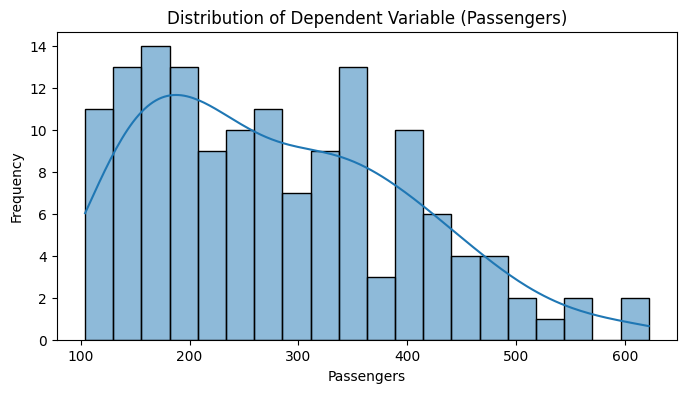

In [9]:
# Plot data as a histogram as you normally would for any numerical data

# Plot histogram to see distribution and outliers
plt.figure(figsize=(8, 4))
sns.histplot(timeseries_df['dependent_var'], bins=20, kde=True)
plt.title("Distribution of Dependent Variable (Passengers)")
plt.xlabel("Passengers")
plt.ylabel("Frequency")
plt.show()

### 2.3. Timeseries analysis

Let's now take a look at the data as a timeseries. There are a couple of things to look out for here.

1. Is the time axis regular? are the rows evenly spaced in time?
2. Is the data stationary? is there a consistent trend over time?
3. Are there regular or cyclical trends?

### 2.3.1. Plot the time-series

Let's include predictions from the baseline model too and see what we are working with.

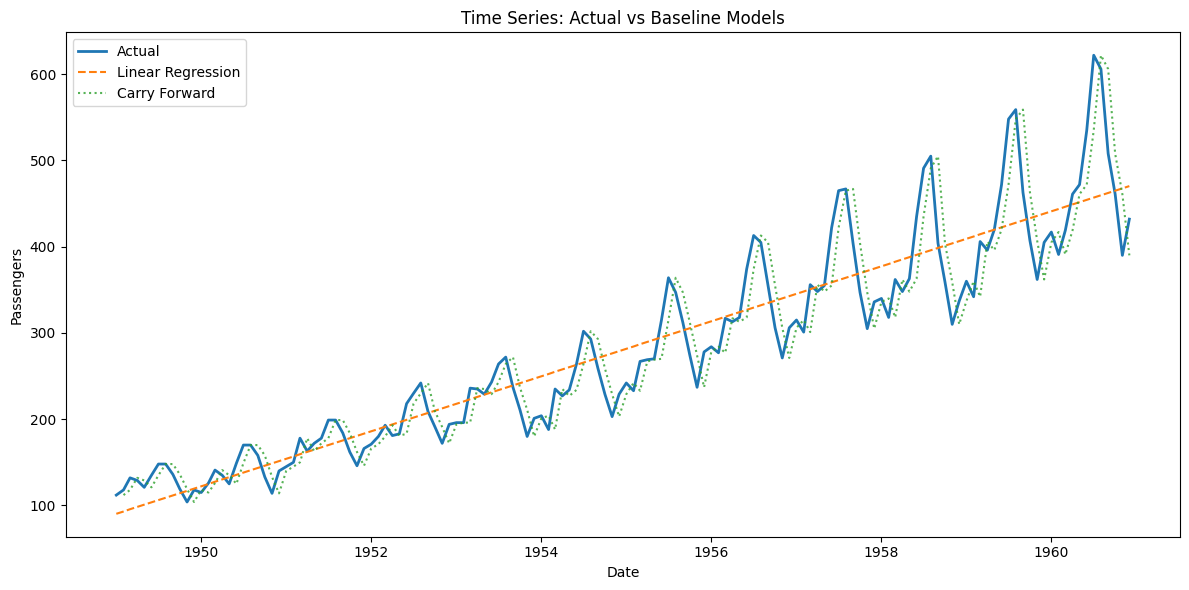

In [11]:
# Plot the data over time and include the linear regression from above
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Actual', linewidth=2)

# Linear regression predictions
plt.plot(timeseries_df.index, y_pred, label='Linear Regression', linestyle='--')

# Carry-forward predictions
plt.plot(data_copy.index, data_copy['carry_forward'], label='Carry Forward', linestyle=':', alpha=0.8)

plt.title("Time Series: Actual vs Baseline Models")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()
plt.show()


### 2.3.2. Missing timepoints

Next, do a quick check to see if the datetime index we just created is evenly spaced - i.e. the time delta between the rows is always the same.

In [12]:
# Your code here. Hint: take a look and Panda's .resample() and numpy's .diff()
# Calculate time differences between consecutive index values
time_deltas = timeseries_df.index.to_series().diff()

# Display unique time differences
print("Unique time intervals:")
print(time_deltas.unique())

# Count them
print("\nInterval counts:")
print(time_deltas.value_counts())


Unique time intervals:
<TimedeltaArray>
[NaT, '31 days', '28 days', '30 days', '29 days']
Length: 5, dtype: timedelta64[ns]

Interval counts:
date
31 days    83
30 days    48
28 days     9
29 days     3
Name: count, dtype: int64


### 2.3.3. Stationarity

In [13]:
# Note: you want to be aware of this property of your data, but you may or may not have to do anything with this information right away!
# Use the adfuller() test from statsmodels.tsa.stattools

from statsmodels.tsa.stattools import adfuller

# Run the ADF test
result = adfuller(timeseries_df['dependent_var'])

# Display results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')
    
# Interpretation
if result[1] < 0.05:
    print("\n✅ The data is likely stationary (reject H0).")
else:
    print("\n⚠️ The data is likely non-stationary (fail to reject H0).")


ADF Statistic: 0.8153688792060655
p-value: 0.9918802434376413
Critical Value (1%): -3.4816817173418295
Critical Value (5%): -2.8840418343195267
Critical Value (10%): -2.578770059171598

⚠️ The data is likely non-stationary (fail to reject H0).


### 2.3.4. Seasonality

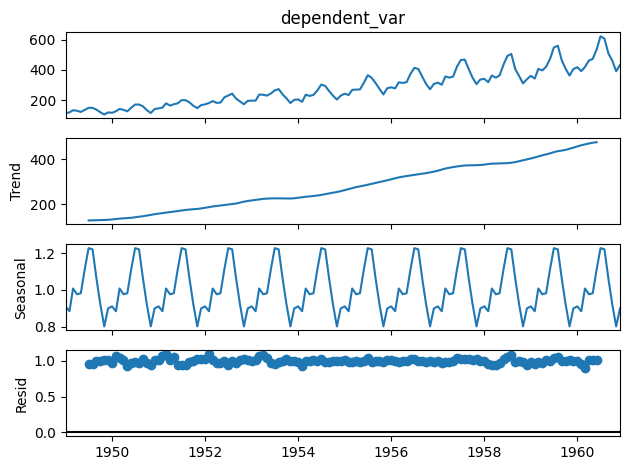

In [14]:
# Note: you want to be aware of this property of your data, but you may or may not have to do anything with this information right away!
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(timeseries_df['dependent_var'], model='multiplicative', period=12)

# Plot the components
decomposition.plot()
plt.tight_layout()
plt.show()


## 3. Model training

In [18]:
# Hint use the 'auto_arima()' function from pmdarima as described in the reading on 4Geeks.

# Fit auto_arima model
arima_model = auto_arima(
    timeseries_df['dependent_var'], 
    seasonal=True, 
    m=12,  
    trace=True, 
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=1.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.18 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.71 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.19 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=1.00 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.27 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.89 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.74 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.43 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.77 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.04 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=1019.084, Time=0.16

## 4. Model evaluation

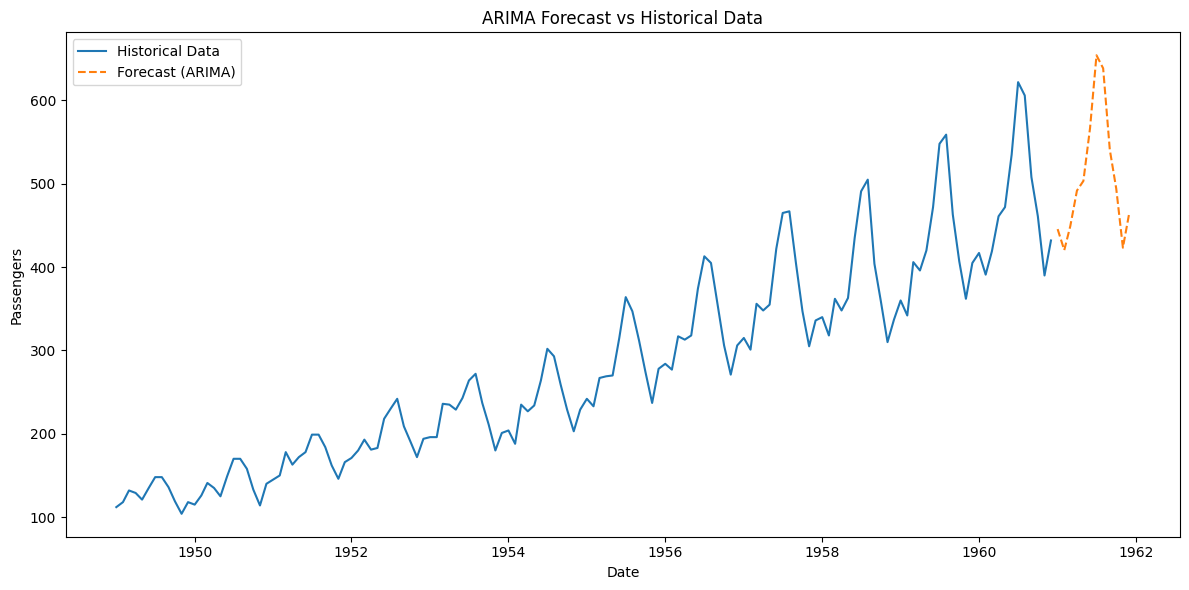

In [19]:
# Plot the forecast for a small number of future points with .predict() on your ARIMA model. Also plot
# the input time series on the same plot

# Forecast next 12 months
forecast = arima_model.predict(n_periods=12)

# Create future datetime index
last_date = timeseries_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

# Plot original + forecast
plt.figure(figsize=(12, 6))
plt.plot(timeseries_df['dependent_var'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecast (ARIMA)', linestyle='--')
plt.title("ARIMA Forecast vs Historical Data")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()
plt.show()


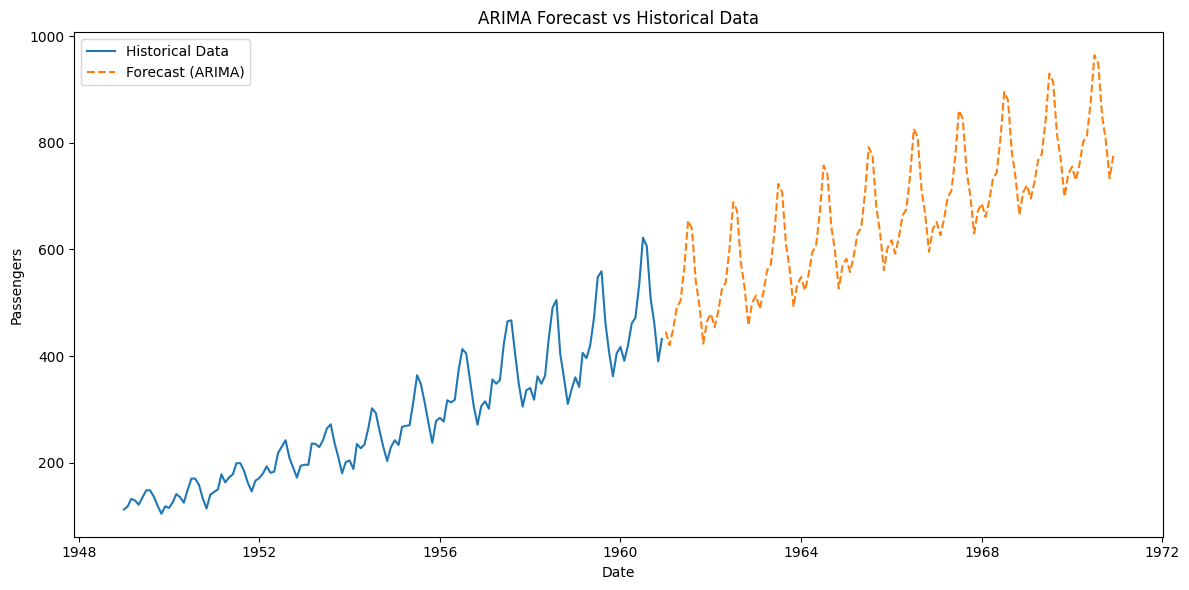

In [22]:
# Try plotting predicting farther into the future - do the predictions still look as good?
# Forecast next 12 months
forecast = arima_model.predict(n_periods=120)

# Create future datetime index
last_date = timeseries_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=120, freq='MS')

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

# Plot original + forecast
plt.figure(figsize=(12, 6))
plt.plot(timeseries_df['dependent_var'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecast (ARIMA)', linestyle='--')
plt.title("ARIMA Forecast vs Historical Data")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()
plt.show()


The results might *look* convincing, at least if you don't look too closely - but how well are we actually doing? We need to implement train-test splitting and/or cross-validation to estimate the actual performance on unseen data!

Breaking up time-series data is a little bit harder than other types of tabular data - we can't just randomly select data points for the training and/or validation sets because the order matters!

Luckily, Scikit-learn can help us out here - take a look at [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [24]:
# Implement test-train splitting and cross-validation using time-series split to properly evaluate the model.
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split into train/test
n_test = 12
train = timeseries_df.iloc[:-n_test]
test = timeseries_df.iloc[-n_test:]

# 1. Linear Regression Baseline
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train['dependent_var'].values
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

rmse_lr = sqrt(mean_squared_error(test['dependent_var'], lr_preds))

# 2. Carry Forward Model
carry_preds = test['dependent_var'].copy()
carry_preds.iloc[0] = train['dependent_var'].iloc[-1]
carry_preds.iloc[1:] = test['dependent_var'].iloc[:-1].values

rmse_carry = sqrt(mean_squared_error(test['dependent_var'], carry_preds))


# 3. ARIMA Model
# Use same model from earlier — retrain on train set
from pmdarima import auto_arima

arima_model = auto_arima(
    train['dependent_var'], 
    seasonal=True, 
    m=12, 
    suppress_warnings=True,
    stepwise=True
)

# Forecast the test period
arima_preds = arima_model.predict(n_periods=n_test)

rmse_arima = sqrt(mean_squared_error(test['dependent_var'], arima_preds))

# Print Comparison
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Carry Forward RMSE:     {rmse_carry:.2f}")
print(f"ARIMA RMSE:             {rmse_arima:.2f}")


Linear Regression RMSE: 78.82
Carry Forward RMSE:     53.15
ARIMA RMSE:             18.54


In [36]:
# Input cross-validation

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from math import sqrt
import numpy as np

# Prepare data
X_all = np.arange(len(timeseries_df)).reshape(-1, 1)
y_all = timeseries_df['dependent_var'].values

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Store RMSE for each model across folds
rmse_lr_list = []
rmse_cf_list = []
rmse_arima_list = []

# Loop through each fold
for fold, (train_index, test_index) in enumerate(tscv.split(X_all), start=1):
    X_train, X_test = X_all[train_index], X_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]

    # ---- Linear Regression ----
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    rmse_lr = sqrt(mean_squared_error(y_test, y_pred_lr))
    rmse_lr_list.append(rmse_lr)

    # ---- Carry Forward ----
    carry_preds = np.empty_like(y_test)
    carry_preds[0] = y_train[-1]  # last value from training set
    carry_preds[1:] = y_test[:-1] # use test set's previous values
    rmse_cf = sqrt(mean_squared_error(y_test, carry_preds))
    rmse_cf_list.append(rmse_cf)

    # ---- ARIMA (fit on y_train only) ----
if len(y_train) > 2 * 12:
    arima = auto_arima(
        y_train,
        seasonal=True,
        m=12,
        suppress_warnings=True,
        stepwise=True
    )
    y_pred_arima = arima.predict(n_periods=len(y_test))
    rmse_arima = sqrt(mean_squared_error(y_test, y_pred_arima))
else:
    y_pred_arima = [np.nan] * len(y_test)  # placeholder predictions
    rmse_arima = np.nan

    rmse_arima_list.append(rmse_arima)

    # print per fold 
    print(f"Fold {fold}:")
    print(f"  Linear Regression RMSE: {rmse_lr:.2f}")
    print(f"  Carry Forward RMSE:     {rmse_cf:.2f}")
    print(f"  ARIMA RMSE:             {rmse_arima:.2f}")
    print("-" * 40)

# Final average scores
print("Average RMSE across all folds:")
print(f"Linear Regression: {np.mean(rmse_lr_list):.2f}")
print(f"Carry Forward:     {np.mean(rmse_cf_list):.2f}")
print(f"ARIMA:             {np.mean(rmse_arima_list):.2f}")


Average RMSE across all folds:
Linear Regression: 50.75
Carry Forward:     33.99
ARIMA:             nan


/home/vscode/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vscode/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
